## Fit an SI pair model with gender to real data

Produces Figure 2 in the paper


## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm
import scipy.stats as stats 
import numdifftools as nd # This may need to be installed on your sustem using conda, pip etc.
import numpy.linalg as LA

## Data, Parameters and Initial Conditions

In [2]:
observed_data = np.array([
    [1742, 22, 21, 17],  # First observation: [msfs_pairs, mifs_pairs, msfi_pairs, mifi_pairs]
    [1721, 33, 25, 23]   # Second observation: [ss_pairs, si_pairs, ii_pairs]
])
time_points = [0, 2]  # Time points corresponding to the observations (years)

In [3]:
# To motivate some reasonable initial conditions
mlambda_ = (observed_data[1,1] - observed_data[0,1])/(4 * observed_data[0,0])
print(mlambda_)
mtau_ = tau = (observed_data[1,3] - observed_data[0,3])/(2 * observed_data[0,1])
print(mtau_)
flambda_ = (observed_data[1,2] - observed_data[0,2])/(4 * observed_data[0,0])
print(flambda_)
ftau_ = tau = (observed_data[1,3] - observed_data[0,3])/(2 * observed_data[0,2])
print(ftau_)

initial_guess = np.array([mlambda_, mtau_, flambda_, ftau_]) # Array of initial guesses for parameters

0.0015786452353616532
0.13636363636363635
0.000574052812858783
0.14285714285714285


In [4]:
# Initial conditions for the model
total_pairs = np.sum(observed_data[0])  # Total pairs from the first observation

# State vector for the ODE solver
initial_state = observed_data[0]  # Use the first observation as initial conditions

## Differential Equations

In [5]:
# Define the differential equations for the epidemic model
def epidemic_model(t, y, mlam, mtau, flam, ftau):
    P_msfs, P_mifs, P_msfi, P_mifi = y
    dP_msfs = - (mlam + flam) * P_msfs
    dP_mifs = mlam * P_msfs - (mtau + flam) * P_mifs
    dP_msfi = flam * P_msfs - (mlam + ftau) * P_msfi
    dP_mifi = (mtau + flam) * P_mifs + (mlam + ftau) * P_msfi
    return [dP_msfs, dP_mifs, dP_msfi, dP_mifi]

## Solving the System of Equations

In [6]:
def odefun(t, x, mlam, mtau, flam, ftau):
    return epidemic_model(t, x, mlam, mtau, flam, ftau)

# Test ODE solver with the initial guess parameters
sol = solve_ivp(
    lambda t, y: odefun(t, y, mlambda_, mtau_, flambda_, ftau_),
    (time_points[0], time_points[-1]),
    initial_state,
    t_eval=np.linspace(0, 2, 2)
)

## Plotting Results

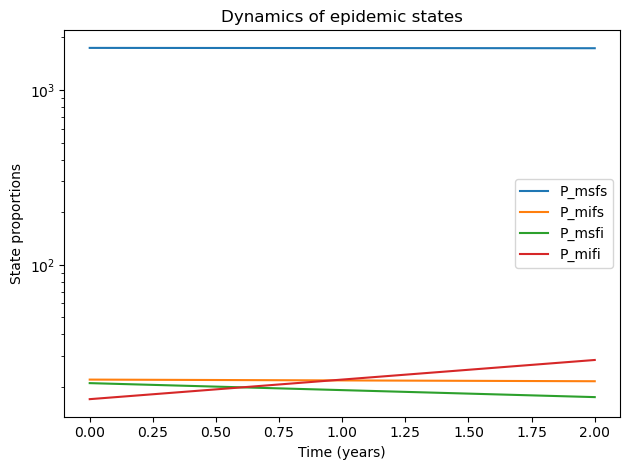

In [7]:
# Plot the results
plt.plot(sol.t, sol.y.T)
plt.legend(["P_msfs", "P_mifs", "P_msfi", "P_mifi"])
plt.xlabel("Time (years)")
plt.ylabel("State proportions")
plt.title("Dynamics of epidemic states")
plt.yscale('log') # Just to confirm they're not flat lines
plt.tight_layout()

## Log-Likelihood Function

In [8]:
def myll(mlam, mtau, flam, ftau):
    odefun = lambda t, x: epidemic_model(t,x,mlam, mtau, flam, ftau) 
    sol = solve_ivp(odefun, (time_points[0], time_points[-1]), initial_state, t_eval=time_points)
    model_predictions = sol.y.T
    prob_predictions = model_predictions / total_pairs
    prob_predictions = np.clip(prob_predictions, 1e-10, 1 - 1e-10)
    ll = 0
    for i, obs in enumerate(observed_data):
        ll += stats.multinomial.logpmf(obs, total_pairs, prob_predictions[i])

    return ll

In [9]:
# Negative log-likelihood function for 4 parameters
neg_log_likelihood = lambda params: -myll(params[0], params[1], params[2], params[3])

In [10]:
def mycall(x):
    print(f'Trying parameters: mlambda={x[0]:.5f}, mtau={x[1]:.5f}, flambda={x[2]:.5f}, ftau={x[3]:.5f}')

In [11]:
# Define bounds for the parameters (non-negative rates)
bounds = [(0, None), (0, None), (0, None), (0, None)]

# Estimate parameters using a bounded optimization method
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds, callback=mycall)
# Display the optimization result
print(result)

# Extract the estimated parameters
xhat = result.x
print(f'Estimated parameters: mlambda={xhat[0]:.5f}, mtau={xhat[1]:.5f}, flambda={xhat[2]:.5f}, ftau={xhat[3]:.5f}')

Trying parameters: mlambda=0.00473, mtau=0.13636, flambda=0.00305, ftau=0.14286
Trying parameters: mlambda=0.00487, mtau=0.13633, flambda=0.00282, ftau=0.14283
Trying parameters: mlambda=0.00493, mtau=0.13628, flambda=0.00273, ftau=0.14279
Trying parameters: mlambda=0.00495, mtau=0.13622, flambda=0.00271, ftau=0.14274
Trying parameters: mlambda=0.00506, mtau=0.13546, flambda=0.00261, ftau=0.14211
Trying parameters: mlambda=0.00518, mtau=0.13382, flambda=0.00250, ftau=0.14076
Trying parameters: mlambda=0.00539, mtau=0.12869, flambda=0.00230, ftau=0.13650
Trying parameters: mlambda=0.00562, mtau=0.11657, flambda=0.00204, ftau=0.12644
Trying parameters: mlambda=0.00572, mtau=0.09128, flambda=0.00174, ftau=0.10543
Trying parameters: mlambda=0.00533, mtau=0.05993, flambda=0.00164, ftau=0.07937
Trying parameters: mlambda=0.00429, mtau=0.04212, flambda=0.00166, ftau=0.06442
Trying parameters: mlambda=0.00397, mtau=0.04419, flambda=0.00218, ftau=0.06606
Trying parameters: mlambda=0.00395, mtau

In [12]:
# Compute the Hessian with a larger step size
hessian_func = nd.Hessian(neg_log_likelihood, step=1e-4)  # Increase step size
H = hessian_func(xhat)

# Print the Hessian matrix
print("Hessian matrix:")
print(H)

# Regularize the Hessian by adding a small value to the diagonal
regularization = 1e-4 * np.eye(len(xhat))  # Increase regularization strength
H_reg = H + regularization

# Compute the covariance matrix
try:
    covmat = LA.inv(0.5 * (H_reg + H_reg.T))
    stds = np.sqrt(np.diag(covmat))
    print("Standard errors:", stds)
except LA.LinAlgError:
    print("Hessian is still singular. Try increasing regularization strength or simplifying the model.")

Hessian matrix:
[[ 3.36176288e+05 -4.78439606e+03 -3.53228329e+03  4.70776695e+02]
 [-4.78439606e+03  2.05511105e+02  7.71055056e+02  9.87544809e+01]
 [-3.53228329e+03  7.71055056e+02  4.25030543e+05 -4.99739194e+03]
 [ 4.70776695e+02  9.87544809e+01 -4.99739194e+03  1.54615691e+02]]
Standard errors: [0.09069367 5.76082703 0.09067942 6.88655296]


In [13]:
print(
    'Estimate of mlambda = {:0.5f}[{:0.5f},{:0.5f}].'.format(
        xhat[0],
        max(0, xhat[0] - 1.96*np.sqrt(covmat[0, 0])),  # Ensure non-negative lower bound
        xhat[0] + 1.96*np.sqrt(covmat[0, 0])  # Upper bound remains unchanged
    )
)
print(
    'Estimate of mtau = {:0.4f}[{:0.4f},{:0.4f}].'.format(
        xhat[1],
        max(0, xhat[1] - 1.96*np.sqrt(covmat[1, 1])),
        xhat[1] + 1.96*np.sqrt(covmat[1, 1])
    )
)
print(
    'Estimate of flambda = {:0.5f}[{:0.5f},{:0.5f}].'.format(
        xhat[2],
        max(0, xhat[2] - 1.96*np.sqrt(covmat[2, 2])),
        xhat[2] + 1.96*np.sqrt(covmat[2, 2])
    )
)
print(
    'Estimate of ftau = {:0.5f}[{:0.5f},{:0.5f}].'.format(
        xhat[3],
        max(0, xhat[3] - 1.96*np.sqrt(covmat[3, 3])),
        xhat[3] + 1.96*np.sqrt(covmat[3, 3])
    )
)


Estimate of mlambda = 0.00395[0.00000,0.18171].
Estimate of mtau = 0.0465[0.0000,11.3377].
Estimate of flambda = 0.00211[0.00000,0.17984].
Estimate of ftau = 0.06797[0.00000,13.56562].


In [14]:
# Define central difference method manually
def finite_diff_se(f, x, h=1e-3):
    n = len(x)
    h_vec = np.diag(np.full(n, h))
    var = np.zeros(n)
    for i in range(n):
        x1 = x.copy()
        x2 = x.copy()
        x1[i] -= h
        x2[i] += h
        f1 = f(x1)
        f2 = f(x2)
        # Central difference approx. second derivative
        second_deriv = (f2 - 2*f(x) + f1) / (h**2)
        if second_deriv > 0:
            var[i] = 1.0 / second_deriv
        else:
            var[i] = np.nan  # Avoid invalid estimates
    return np.sqrt(var)

# Apply to get standard errors
stds = finite_diff_se(neg_log_likelihood, xhat, h=1e-3)

# Print results
param_names = ['mlambda', 'mtau', 'flambda', 'ftau']
print("Standard errors (finite difference):", stds)

for i in range(len(xhat)):
    if not np.isnan(stds[i]):
        lower = max(0, xhat[i] - 1.96 * stds[i])
        upper = xhat[i] + 1.96 * stds[i]
        print(f'{param_names[i]} = {xhat[i]:.5f} [{lower:.5f}, {upper:.5f}]')
    else:
        print(f'{param_names[i]} = {xhat[i]:.5f} [NA, NA] (unstable curvature)')


Standard errors (finite difference): [0.00172054 0.06975595 0.0015277  0.08042156]
mlambda = 0.00395 [0.00058, 0.00732]
mtau = 0.04650 [0.00000, 0.18322]
flambda = 0.00211 [0.00000, 0.00511]
ftau = 0.06797 [0.00000, 0.22560]


In [15]:
# Define parameter ranges for heatmaps
mlambda_range = np.arange(0.0, 0.0126, 0.0001)
mtau_range = np.arange(0.0, 0.401, 0.001)
flambda_range = np.arange(0.0, 0.0101, 0.0001)
ftau_range = np.arange(0.0, 0.501, 0.001)

In [16]:
# Preallocate log-likelihood values
log_likelihood_m = np.zeros((len(mlambda_range), len(mtau_range)))
log_likelihood_f = np.zeros((len(flambda_range), len(ftau_range)))

In [17]:
# Calculate log-likelihood for each grid point
for i, mlambda in enumerate(tqdm(mlambda_range)):
    for j, mtau in enumerate(mtau_range):
        log_likelihood_m[i, j] = myll(mlambda, mtau, xhat[2], xhat[3])

for i, flambda in enumerate(tqdm(flambda_range)):
    for j, ftau in enumerate(ftau_range):
        log_likelihood_f[i, j] = myll(xhat[0], xhat[1], flambda, ftau)

100%|███████████████████████████████████████| 101/101 [00:06<00:00, 15.13it/s]


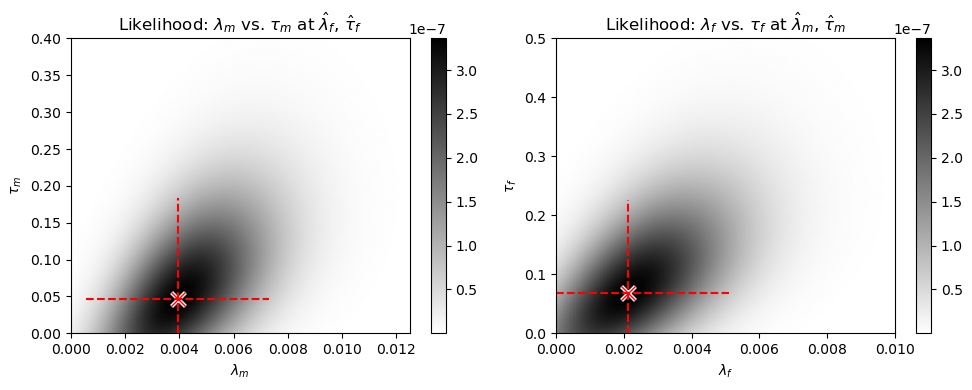

In [18]:
import matplotlib.pyplot as plt

# Confidence intervals (from earlier stds output)
cis = []
for i in range(len(xhat)):
    if not np.isnan(stds[i]):
        lower = max(0, xhat[i] - 1.96 * stds[i])
        upper = xhat[i] + 1.96 * stds[i]
        cis.append((lower, upper))
    else:
        cis.append((np.nan, np.nan))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# --- Heatmap for mlambda vs mtau ---
im1 = axs[0].imshow(
    np.exp(log_likelihood_m).T,
    cmap='binary',
    aspect='auto',
    origin='lower',
    extent=(mlambda_range[0], mlambda_range[-1], mtau_range[0], mtau_range[-1]),
    #vmin=np.max(log_likelihood_m) - 20
)
axs[0].scatter(xhat[0], xhat[1], marker='x', c='w', s=100, lw=3)
axs[0].scatter(xhat[0], xhat[1], marker='x', c='r', s=100, lw=1)

# "+" style CI cross for mlambda/mtau
axs[0].vlines(xhat[0], ymin=cis[1][0], ymax=cis[1][1], color='r', linestyle='--')  # vertical line at xhat[0]
axs[0].hlines(xhat[1], xmin=cis[0][0], xmax=cis[0][1], color='r', linestyle='--')  # horizontal line at xhat[1]

axs[0].set_title(r'Likelihood: $\lambda_m$ vs. $\tau_m$ at $\hat{\lambda}_f$, $\hat{\tau}_f$')
axs[0].set_xlabel(r'$\lambda_m$')
axs[0].set_ylabel(r'$\tau_m$')
plt.colorbar(im1, ax=axs[0])

# --- Heatmap for flambda vs ftau ---
im2 = axs[1].imshow(
    np.exp(log_likelihood_f).T,
    cmap='binary',
    aspect='auto',
    origin='lower',
    extent=(flambda_range[0], flambda_range[-1], ftau_range[0], ftau_range[-1]),
    #vmin=np.max(log_likelihood_f) - 20
)
axs[1].scatter(xhat[2], xhat[3], marker='x', c='w', s=100, lw=3)
axs[1].scatter(xhat[2], xhat[3], marker='x', c='r', s=100, lw=1)

# "+" style CI cross for flambda/ftau
axs[1].vlines(xhat[2], ymin=cis[3][0], ymax=cis[3][1], color='r', linestyle='--')  # vertical line at xhat[2]
axs[1].hlines(xhat[3], xmin=cis[2][0], xmax=cis[2][1], color='r', linestyle='--')  # horizontal line at xhat[3]

axs[1].set_title(r'Likelihood: $\lambda_f$ vs. $\tau_f$ at $\hat{\lambda}_m$, $\hat{\tau}_m$')
axs[1].set_xlabel(r'$\lambda_f$')
axs[1].set_ylabel(r'$\tau_f$')
plt.colorbar(im2, ax=axs[1])

plt.tight_layout()


Profile: ftau: 100%|██████████████████████| 501/501 [00:00<00:00, 7112.33it/s]


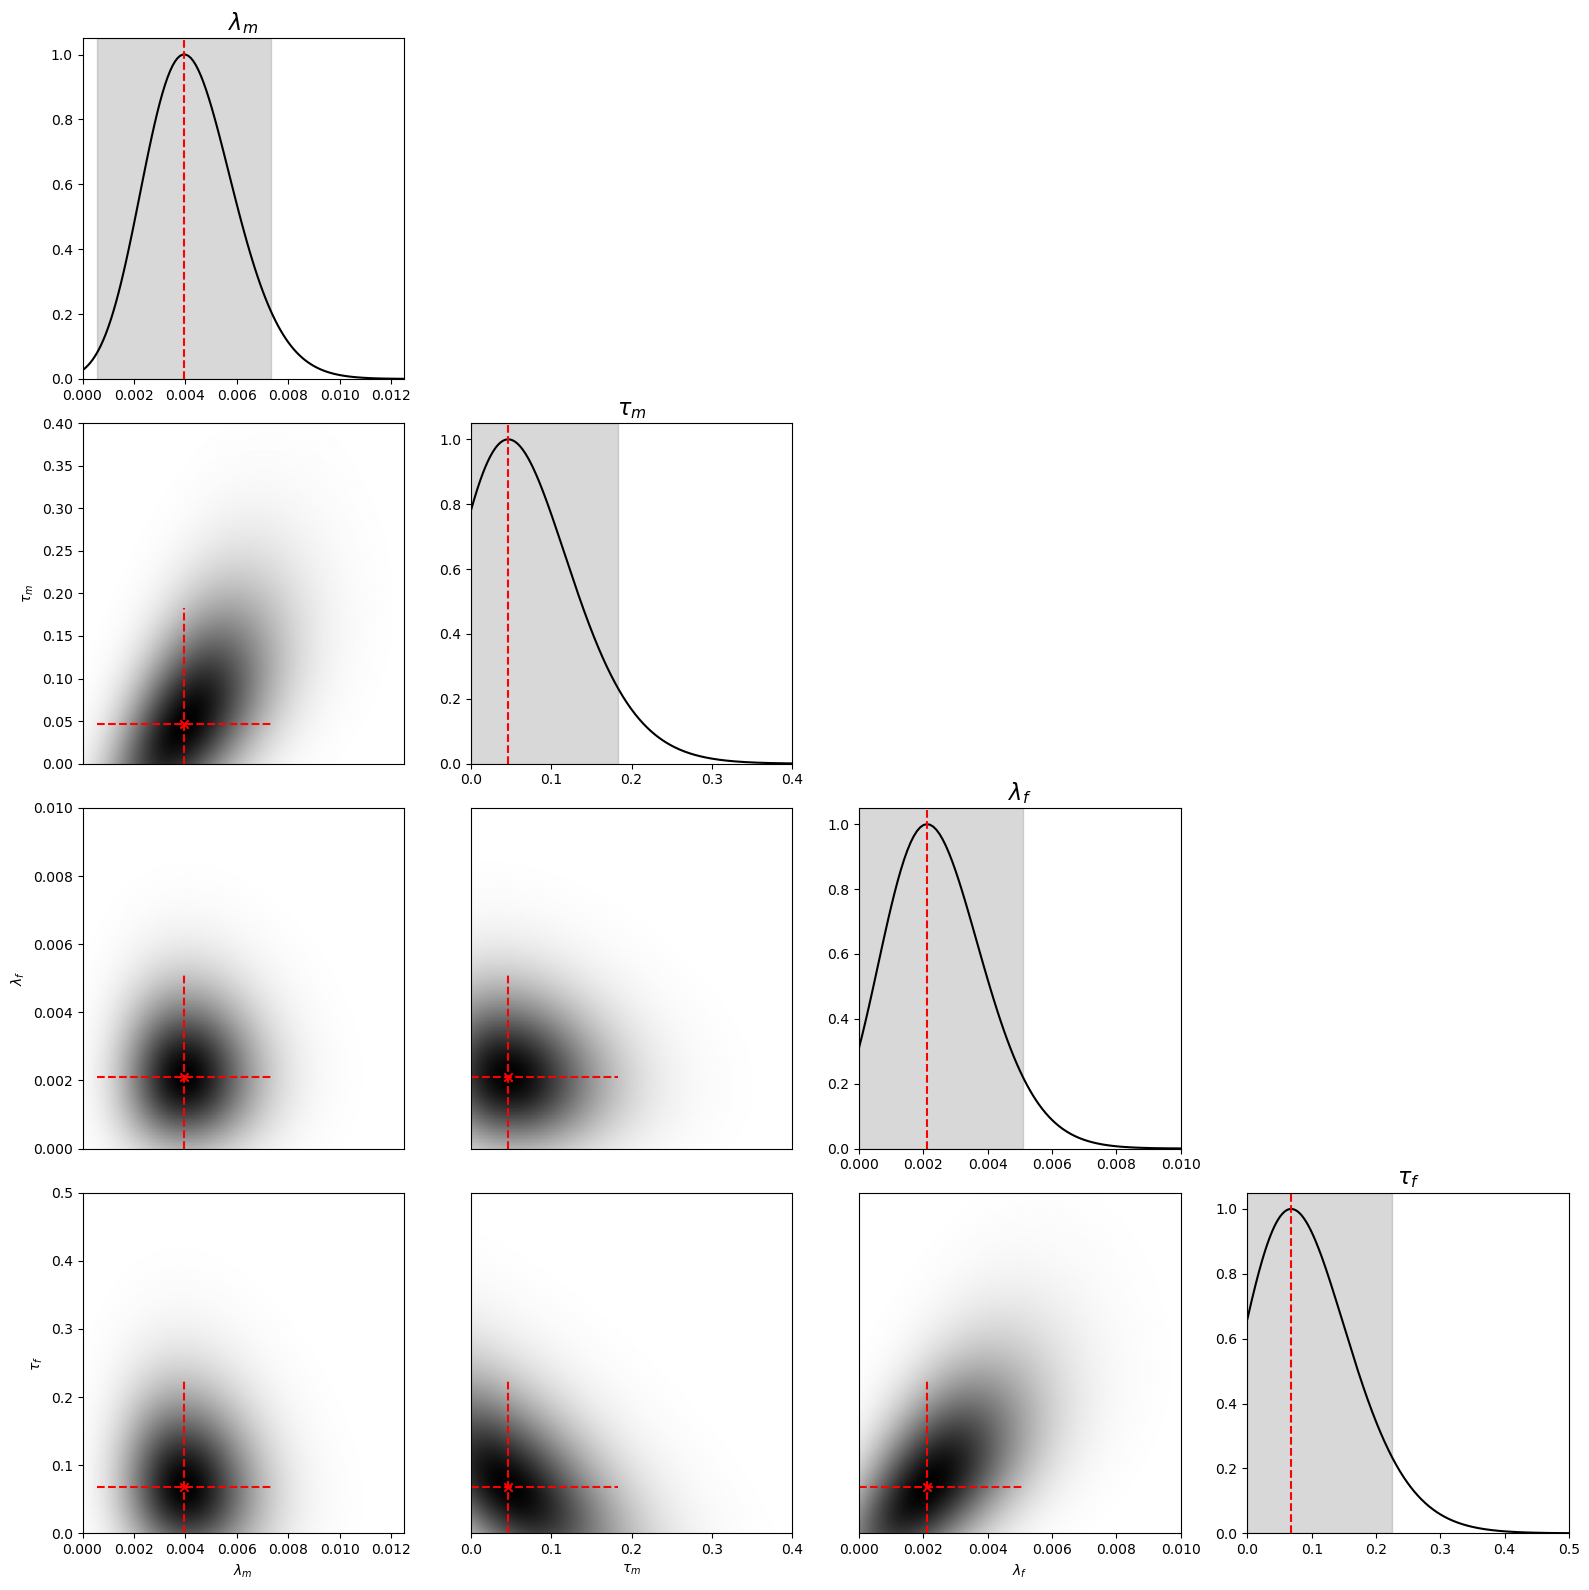

In [19]:
# Parameters

param_index = ['mlambda', 'mtau', 'flambda', 'ftau']
param_labels = {
    'mlambda': r'$\lambda_m$',
    'mtau': r'$\tau_m$',
    'flambda': r'$\lambda_f$',
    'ftau': r'$\tau_f$'
}

# Define parameter ranges for plotting
param_ranges = {
    'mlambda': np.arange(0.0, 0.0126, 0.0001),
    'mtau': np.arange(0.0, 0.401, 0.001),
    'flambda': np.arange(0.0, 0.0101, 0.0001),
    'ftau': np.arange(0.0, 0.501, 0.001)
}

# Ensure stds exists (from finite_diff_se earlier). Recompute if missing
try:
    stds
except NameError:
    stds = finite_diff_se(neg_log_likelihood, xhat, h=1e-3)

# Confidence intervals
cis = []
for i in range(len(xhat)):
    if not np.isnan(stds[i]):
        lower = max(0, xhat[i] - 1.96 * stds[i])
        upper = xhat[i] + 1.96 * stds[i]
        cis.append((lower, upper))
    else:
        cis.append((np.nan, np.nan))

# Best-fit parameters and CIs as dicts
xhat_dict = dict(zip(param_index, xhat))
cis_dict = dict(zip(param_index, cis))

# Plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

for i, param_x in enumerate(param_index):
    for j, param_y in enumerate(param_index):
        ax = axs[j, i]  # rows = Y-axis param, columns = X-axis param

        if i == j:
            # --- Diagonal: profile likelihood ---
            param_range = param_ranges[param_x]
            logL_vals = []
            for val in tqdm(param_range, desc=f'Profile: {param_x}'):
                p = xhat_dict.copy()
                p[param_x] = val
                logL_vals.append(myll(p['mlambda'], p['mtau'], p['flambda'], p['ftau']))

            logL_vals = np.array(logL_vals)
            ax.plot(param_range, np.exp(logL_vals - np.max(logL_vals)), color='black')
            ax.axvline(xhat_dict[param_x], color='red', linestyle='--')
            ax.axvspan(cis_dict[param_x][0], cis_dict[param_x][1], color='gray', alpha=0.3)
            ax.set_xlim(param_range[0], param_range[-1])
            ax.set_ylim([0, 1.05])
            ax.set_title(f'{param_labels[param_x]}', fontsize=16)

        elif j > i:
            # --- Lower triangle: 2D likelihood heatmap ---
            x_range = param_ranges[param_x]
            y_range = param_ranges[param_y]
            logL_grid = np.zeros((len(x_range), len(y_range)))

            for xi, xval in enumerate(tqdm(x_range, desc=f"{param_x} vs {param_y}")):
                for yi, yval in enumerate(y_range):
                    p = xhat_dict.copy()
                    p[param_x] = xval
                    p[param_y] = yval
                    logL_grid[xi, yi] = myll(p['mlambda'], p['mtau'], p['flambda'], p['ftau'])

            ax.imshow(
                np.exp(logL_grid - np.max(logL_grid)).T,
                extent=(x_range[0], x_range[-1], y_range[0], y_range[-1]),
                origin='lower',
                aspect='auto',
                cmap='binary'
            )
            ax.scatter(xhat_dict[param_x], xhat_dict[param_y], c='red', marker='x')
            ax.vlines(xhat_dict[param_x], ymin=cis_dict[param_y][0], ymax=cis_dict[param_y][1], color='r', linestyle='--')
            ax.hlines(xhat_dict[param_y], xmin=cis_dict[param_x][0], xmax=cis_dict[param_x][1], color='r', linestyle='--')

            if j == 3:
                ax.set_xlabel(param_labels[param_x])
            else:
                ax.set_xticks([])

            if i == 0:
                ax.set_ylabel(param_labels[param_y])
            else:
                ax.set_yticks([])

        else:
            # --- Upper triangle: blank ---
            ax.axis('off')

plt.tight_layout()
plt.savefig('./Figure2.pdf')